# Joint lightcurve - radial velocity model with individual priors

In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

4.3.1


In [2]:
from isochrones import get_ichrone
# mist = get_ichrone('mist',bands=['GAIA_G_EDR3'])
# mist.generate(1.0,9.0,0.02)

Holoviews not imported. Some visualizations will not be available.


# LOAD IN ALLVISIT FILE (an absolute unit: ~ 2.75GB)

In [3]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
allstar17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allStar-dr17-synspec-gaiaedr3-xm.fits")
allstar17 = allstar17[(allstar17['bp_rp'] < 10) & (allstar17['phot_g_mean_mag'] < 25)]
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)


print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
print(len(hq_jk_allstar_tess_edr3))

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>
1741


In [4]:
# fig,ax = plt.subplots(figsize=(16,12))

# ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
# y1,y2 = ax.set_ylim()
# ax.set_ylim(y2,y1)

# ax.plot(hq_jk_allstar_tess_edr3['bp_rp'], 
#         hq_jk_allstar_tess_edr3['phot_g_mean_mag'] 
#          - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
#            , c='red', marker='.', ls='None') 
# ax.set_xlabel("bp - rp")
# ax.set_ylabel("G")

114 57


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_3061/2459686942.py:18: RuntimeWarning: invalid value encountered in log10
  ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_3061/2459686942.py:24: RuntimeWarning: invalid value encountered in log10
  - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


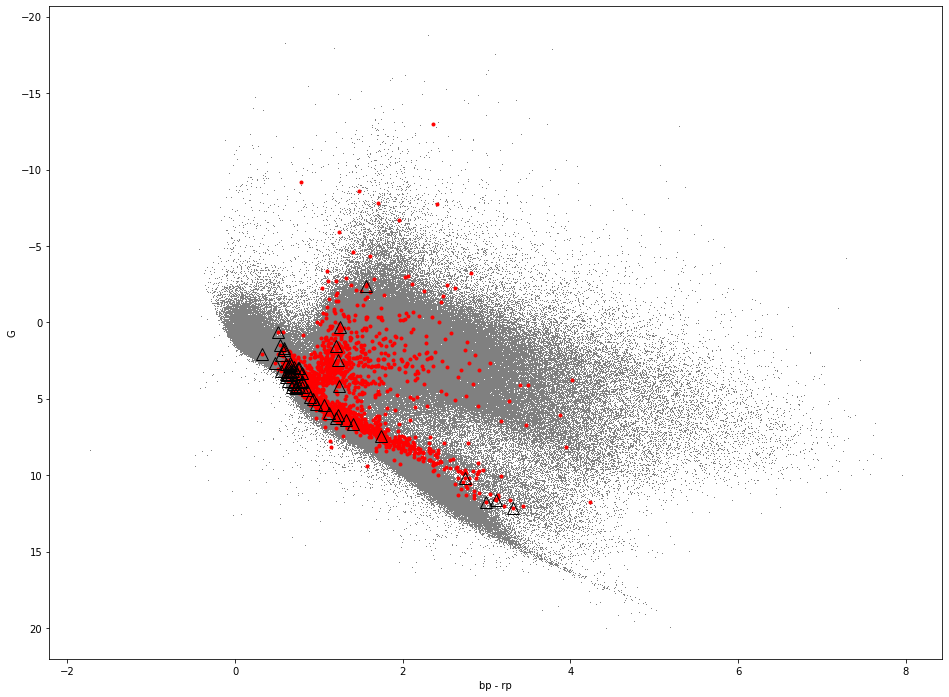

In [5]:
import pickle as pk
import os
dir_ticIDS = os.listdir(dd+'joker_TESS_lightcurve_files')
dir_ticIDS.remove(".DS_Store")

dir_ticIDS = [ii.replace('_lightcurve_data.pickle','') for ii in dir_ticIDS]
dir_ticIDS = [ii.replace('_highres_bls_params.pickle','') for ii in dir_ticIDS]

print(len(dir_ticIDS),len(np.unique(dir_ticIDS)))
dir_ticIDS = np.unique(dir_ticIDS)
right_ids = 0

has_tess_obs = np.in1d(hq_jk_allstar_tess_edr3['ID'],[int(ii.split('_')[1]) for ii in dir_ticIDS])
hq_jk_allstar_tess_edr3_w_tess_obs = hq_jk_allstar_tess_edr3[has_tess_obs]

fig,ax = plt.subplots(figsize=(16,12))

ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
y1,y2 = ax.set_ylim()
ax.set_ylim(y2,y1)

ax.plot(hq_jk_allstar_tess_edr3['bp_rp'], 
        hq_jk_allstar_tess_edr3['phot_g_mean_mag'] 
         - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
           , c='red', marker='.', ls='None') 
ax.set_xlabel("bp - rp")
ax.set_ylabel("G")

ax.plot(hq_jk_allstar_tess_edr3_w_tess_obs['bp_rp'],
        hq_jk_allstar_tess_edr3_w_tess_obs['phot_g_mean_mag']
        - (5.*np.log10(1000./hq_jk_allstar_tess_edr3_w_tess_obs['parallax']) - 5)
        , c='black', marker='^', ms=12,ls='None',mfc='None')

file = open("/Users/kjaehnig/CCA_work/GAT/tic_ids_of_systems_with_short_cadence_obs.txt",'w')
for ii in dir_ticIDS:
    file.write(ii+'\n')
file.close()

In [6]:
# big_tess_lc_dict = {}
# print(dir_ticIDS)
# for ii in dir_ticIDS:
#     file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{ii}_lightcurve_data.pickle",'rb')
#     res = pk.load(file)
#     file.close()
#     big_tess_lc_dict[ii] = res
# file = open("/Users/kjaehnig/CCA_work/GAT/big_lightcurve_dict_shortcadence_tess_obs","wb")
# pk.dump(big_tess_lc_dict, file)
# file.close()



In [7]:
# fig,ax = plt.subplots(figsize=(16,12))
# ax.hist(hq_jk_allstar_tess_edr3['phot_g_mean_mag'])

#### Load in relevant cross-matches and grab Joker Params for specific TIC ID

In [8]:
target_tic = 'TIC 20215451'
def grab_apogee_rv_data_w_ticID(target_tic='TIC 20215452'):
#     target_tic = 'TIC 20215452'

    #cross-matched star table (has source_id, apogee_id, TIC_id)
    hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')

    #Adrian's calibrated RV_ERRs
    calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)
#     print(calibverr.info)
    # Grab cross-match IDs
    jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == int(target_tic.split(' ')[1])]


    sysapodat = allvis17[allvis17['APOGEE_ID'] == jk_row['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
#     print(calibverr.info, sysapodat.columns)
    x_rv = sysapodat['JD'] 
    xrv_sorted_ind = np.argsort(x_rv)

    x_rv = x_rv[xrv_sorted_ind]
    y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
    yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

    map_t0_bmjd = jk_row['MAP_t0_bmjd']
    t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
    t0_bjd = t0_bmjd.tcb.jd

    return ((x_rv, y_rv, yerr_rv),
            jk_row,
            sysapodat
           )


# rvdat,jk_row,sysapodat = grab_apogee_rv_data_w_ticID(target_tic=target_tic)
# x_rv, y_rv, yerr_rv = rvdat


In [9]:
#### DEFINE THE RV,RV_ERRs, and X_RVs for later use in the mcmc... DO NOT REDEFINE ME OR YOU MAKE PYMC3 SAD
# x_rv = sysapodat['JD'] 
# xrv_sorted_ind = np.argsort(x_rv)

# x_rv = x_rv[xrv_sorted_ind]
# y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
# yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

# map_t0_bmjd = jk_row['MAP_t0_bmjd']
# t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
# t0_bjd = t0_bmjd.tcb.jd

# fit,ax = plt.subplots(nrows=1, figsize=(15,8))
# print(jk_row['MAP_t0_bmjd'], jk_row['MAP_P'])

# plot_per = jk_row['MAP_P'].value
# plot_t0 = t0_bjd


# ax.scatter(((x_rv - plot_t0 + 0.5*plot_per) % plot_per) - 0.5 * plot_per, y_rv-jk_row['MAP_v0'],)
# ax.axhline(0.0,ls='--')
# ax.axvline(0.0,ls='--')
# # 7.689283720758311 d 1901.7952219793171
# # ax.scatter((x_rv-min(x_rv))%jk_row['MAP_P'], y_rv)
# # ax.scatter(((x_rv -min(x_rv) + 0.5*jk_row['MAP_P']) % jk_row['MAP_P']) - 0.5 * jk_row['MAP_P'], y_rv)

# """plot multiple tic ids with folded lightcurves and RVs using the BLS period/t0 from the TESS data
# """

In [10]:
# target_lk = lk.search_lightcurve('TIC 272074664',
#              mission='TESS',
#             cadence='short',
#             author='SPOC'
#              )
# print(target_lk)
# unpro_lks = target_lk.download_all(quality_bitmask='hardest')
# lks = unpro_lks.stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())

# lks_2019 = unpro_lks[:2].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
# lks_2021 = unpro_lks[2:].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
# unpro_lks[0].sector

In [11]:
def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges, inds
# dat,rng,ind = get_multiple_ranges(unpro_lks)

# print(dat)
# print(len(ind))


In [12]:
def get_texp_from_lightcurve(res):
    with fits.open(res['all_lks'].filename) as hdu:
        hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0
    print(texp, texp*60*60*24)

    return texp


In [13]:
from matplotlib import cm


def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges,inds


def get_all_transit_params(TIC_ID, jk_row):
    
    res = {'periods':[],
          'durations':[],
          't0s':[],
          'depths':[]}
    
    period_grid = np.exp(np.linspace(np.log(0.5*jk_row['MAP_P']),
                                     np.log(2.*jk_row['MAP_P']),
                                     10000)).squeeze()
    
#     period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.09),50))

    npts = 5000
    pmin = period_grid.min()
    pmax = period_grid.max()
    mindur = dur_grid.min()

    print("Downloading all available TESS data.")
    lk_search = lk.search_lightcurve(TIC_ID,
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
    
    unprocessed_lkcoll = lk_search.download_all(quality_bitmask='hardest')
    all_lks = unprocessed_lkcoll.stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    print("Separating TESS sector data into groups.")
    _, __, grp_ind = get_multiple_ranges(unprocessed_lkcoll)
    
    for ii,ind in enumerate(grp_ind):
        
        print(f"Running BLS on group {ii}, sectors: {unprocessed_lkcoll[ind].sector}")
        lkgrp = unprocessed_lkcoll[ind].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
        
        maxtime = lkgrp.time.max().value
        mintime = lkgrp.time.min().value

        freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 
        
        lkgrpBLS = lkgrp.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = freq_f, duration=dur_grid)
        
        res['periods'].append(lkgrpBLS.period_at_max_power.value)
        res['t0s'].append(lkgrpBLS.transit_time_at_max_power)
        res['durations'].append(lkgrpBLS.duration_at_max_power.value)
        res['depths'].append(lkgrpBLS.depth_at_max_power)
        
    print("Finished.")
    res['unprocessed_lk_coll'] = unprocessed_lkcoll
    res['all_lks'] = all_lks
    res['period_linspace'] = [0.5*jk_row['MAP_P'], 2.*jk_row['MAP_P'], len(period_grid)]
    res['dur_linspace'] = [0.001,0.09, len(dur_grid)]
    res['freq_factor'] = freq_f
    
    return res

def fold(x, period, t0):
    hp = 0.5 * period
    return (x - t0 + hp) % period - hp

def make_folded_lightcurve_from_blsres(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))

    
    
    lks = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize())
#     print([len(ii) for ii in blsres['period']])
#     print('sectors: ',res['lk_coll'].sector,'\n'\
#           'bls_per(s): ',blsres['period'],'\n'\
#           'MAP_P: ',res['joker_param']['MAP_P'])

    map_period = res['joker_param']['MAP_P']
    map_t0_bmjd = res['joker_param']['MAP_t0_bmjd']
    map_t0 = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')

    bls_period = blsres['period_at_max_power'].value
    bls_t0 = blsres['t0_at_max_power'].value
        
    rv_time = astropy.time.Time(sysapodat['MJD'], format='mjd', scale='tcb')

    abs_time_vmin = 0.0
    abs_time_vmax = max(lks.time.btjd.max()-lks.time.btjd.min(), rv_time.btjd.max()-rv_time.btjd.min())
#     print(abs_time_vmin, abs_time_vmax)
    
    fig,ax = plt.subplots(figsize=(16,20), nrows=4, ncols=2)
#     ax[-1,-1].remove()
    
    fig.text(0.5,0.885,f'un-folded observations (TESS --- APOGEE) [{TICID}]',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    lc_unfolded = ax[0,0].scatter(lks.time.value, lks.flux.value,marker='o', s=0.5,
                              c=lks.time.value - lks.time.min().value, 
                                  vmin=abs_time_vmin, vmax=abs_time_vmax, cmap=cm.inferno)

    rv_unfolded = ax[0,1].plot(rv_time.btjd, 
                               sysapodat['VHELIO'] - res['joker_param']['MAP_v0'],
                               marker='o',ls='None',mec='black')
    
    fig.text(0.5,0.69,'bls folded observations (TESS --- APOGEE)',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    
    Nbins = 100  # int(len(lks.time.value) / 1000.)
    bins = np.linspace(-0.5*bls_period, 0.5*bls_period, Nbins)
    x_ = fold(lks.time.value, bls_period, bls_t0)
    y_ = lks.flux.value
    num, _ = np.histogram(x_, bins, weights=y_)
    denom, _ = np.histogram(x_, bins)
    num[denom > 0] /= denom[denom > 0]
    num[denom == 0] = np.nan
#     def running_mean(x, N):
#         cumsum = np.cumsum(np.insert(x, 0, 0)) 
#         return (cumsum[N:] - cumsum[:-N]) / float(N)
    
#     folded_lcx = fold(lks.time.value, bls_period, bls_t0)
#     inds = np.argsort(folded_lcx)
    
#     folded_rmy = running_mean(lks.flux.value[inds],Nbins)
    
#     rmx = np.linspace(folded_lcx.min(), folded_lcx.max(), len(folded_rmy))
#     folded_rmx = fold(rmx, bls_period, bls_t0)
    
    lc_folded_bls = ax[1,0].scatter(fold(lks.time.value, bls_period, bls_t0), 
               lks.flux.value, marker='o',s=0.5,
               c=lks.time.value - lks.time.min().value,
               cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax#fold(lks.time.value, bls_period, bls_t0)
                )
    ax[1,0].plot(0.5 * (bins[1:] + bins[:-1]), num, color='white', lw=6,zorder=10)
    ax[1,0].plot(0.5 * (bins[1:] + bins[:-1]), num, color='cyan', lw=3,zorder=11)
#     ax[1,0].set_ylim(lks.flux.min(), lks.flux.max())
    
    rv_folded_bls = ax[1,1].scatter(fold(sysapodat['MJD'].value, bls_period, blsres['t0_at_max_power'].mjd),
                                    sysapodat['VHELIO']-res['joker_param']['MAP_v0'],
                                    marker='o',c=sysapodat['MJD'].value-min(sysapodat['MJD']),
                                    cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax,
                                    ec='black')
    ax[1,1].axvline(0.0,ls='--')
    ax[1,1].axhline(0.0,ls='--')

    fig.text(0.5,0.49,'MAP folded observations (TESS --- APOGEE)',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    lc_folded_map = ax[2,0].scatter(fold(lks.time.value, map_period, map_t0.btjd), 
               lks.flux.value, marker='o',s=0.5,
               c=lks.time.value - lks.time.min().value,
               cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax#fold(lks.time.value, bls_period, bls_t0)
                )
    
    rv_folded_map = ax[2,1].scatter(fold(sysapodat['MJD'].value, map_period, map_t0.mjd),
                                    sysapodat['VHELIO']-res['joker_param']['MAP_v0'],
                                    marker='o',c=sysapodat['MJD'].value-min(sysapodat['MJD']),
                                    cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax,
                                    ec='black')
    fig.colorbar(rv_folded_map, ax=ax[1:3,1],shrink=1.0, pad=0.01, fraction=0.05,label='days')
    ax[2,1].axvline(0.0,ls='--')
    ax[2,1].axhline(0.0,ls='--')
    
    ax[3,0].set_title("GAIA CMD Target Location", fontsize=14, fontweight='bold')
    allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
    unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
    tess_obs_Gmag = hq_jk_allstar_tess_edr3_w_tess_obs['phot_g_mean_mag'] - (
                        5.*np.log10(1000./hq_jk_allstar_tess_edr3_w_tess_obs['parallax']) - 5)
    target_Gmag = res['joker_param']['phot_g_mean_mag'] - (5.*np.log10(1000./res['joker_param']['parallax']) - 5.)
    
    ax[3,0].plot(allstar17['bp_rp'], allstar_Gmag,
                 marker=',',color='gray', ls='None',label='allstar')
    ax[3,0].plot(hq_jk_allstar_tess_edr3['bp_rp'],unimodal_Gmag,
                 marker='.',color='tab:red',ls='None', label='unimodal')
    ax[3,0].plot(hq_jk_allstar_tess_edr3_w_tess_obs['bp_rp'], tess_obs_Gmag,
                 marker='^',ms=8,color='black',ls='None',mfc='None',label='unimodal w TESS')
    ax[3,0].plot(res['joker_param']['bp_rp'],target_Gmag,
                 marker='^',ms=8,color='tab:blue',lw=2,ls='None',label=TICID)
    ax[3,0].set_ylim(15,-15)
    ax[3,0].set_xlim(-1,7)
    ax[3,0].legend(fontsize=10)
    
    joker_param = hq_jk_allstar_tess_edr3.to_pandas()[hq_jk_allstar_tess_edr3['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]
#     print(joker_param['phot_g_mean_mag'])
    param_str = (f"Gaia G: {joker_param['phot_g_mean_mag'].squeeze()}\nTeff: {int(joker_param['TEFF'].squeeze())}\nLogG: {joker_param['LOGG'].squeeze()}\nM_H: {joker_param['M_H'].squeeze()}\necc: {joker_param['MAP_e'].squeeze()}\nMAP_P: {joker_param['MAP_P'].squeeze()}\nBLS_P: {bls_period}")
    ax[3,1].scatter(0,0,ec='None',fc='None',label=param_str)
    ax[3,1].legend(loc='center',scatterpoints=0, fontsize=18, frameon=False)
    
#     fig.colorbar(lc_folded_)
#     ax.set_xlim(-1,1)

In [14]:
# file = open("/Users/kjaehnig/CCA_work/GAT/tic_ids_of_systems_with_short_cadence_obs.txt",'r')
# sys_with_tess_obs = file.read().splitlines()
# file.close()
# print(sys_with_tess_obs)
# for ticid in ['TIC_229536143']:
#     make_folded_lightcurve_from_blsres(ticid)
#     plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_bls_multiplots/{ticid.replace(' ','_').replace('-','_')}_highres_bls_multiplot.png",
#                 dpi=150, bbox_inches='tight')
#     plt.close()

In [15]:
# file = open("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_272074664_highres_bls_params.pickle",'rb')
# blsres = pk.load(file)
# file.close()
# print(blsres['period_at_max_power'])

# file = open("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_272074664_lightcurve_data.pickle","rb")
# res = pk.load(file)
# file.close()

# get_texp_from_lightcurve(res)*24*60

#### consider p/dot
#### find ephermeris between two sets of observations for TIC272074664
#### look at tidal quality factor
#### Consider transit timing variations

In [16]:
# fig,ax = plt.subplots(ncols=2,nrows=2, figsize=(16,16))

# set1 = res['lk_coll'][:2].stitch(corrector_func=lambda x: x.remove_nans().normalize())
# set2 = res['lk_coll'][2:].stitch(corrector_func=lambda x: x.remove_nans().normalize())
# print(res['lk_coll'])

# ax[0,0].plot(fold(set1.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set1.flux.value, marker=',', ls='None',zorder=1,color='red',label='sectors-14,15')
# ax[0,0].plot(fold(set2.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set2.flux.value, marker=',', ls='None',zorder=0, color='black',label='sectors-40,41')
# ax[0,0].set_ylabel('flux',fontsize=20)
# ax[0,0].legend(loc='lower left',frameon=True, fontsize=16)


# ax[0,1].plot(fold(set1.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set1.flux.value, marker=',', ls='None',zorder=0,color='red',label='sectors-14,15')
# ax[0,1].plot(fold(set2.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set2.flux.value, marker=',', ls='None',zorder=1, color='black',label='sectors-40,41')

# ax[1,0].set_ylabel('flux',fontsize=20)
# ax[1,0].set_xlabel('phase',fontsize=20)


# ax[1,0].plot(fold(set1.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set1.flux.value, marker='.', ls='None',zorder=1,color='red',label='sectors-14,15')
# ax[1,0].plot(fold(set2.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set2.flux.value, marker='.', ls='None',zorder=0, color='black',label='sectors-40,41')
# ax[1,0].set_xlim(-0.5,.5)
# ax[1,0].set_ylim(0.925, 1.025)


# ax[1,1].plot(fold(set1.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set1.flux.value, marker='.', ls='None',zorder=0,color='red',label='sectors-14,15')
# ax[1,1].plot(fold(set2.time.value, blsres['period_at_max_power'].value, blsres['t0_at_max_power'].value),
#            set2.flux.value, marker='.', ls='None',zorder=1, color='black',label='sectors-40,41')
# ax[1,1].set_xlim(-0.5,0.5)
# ax[1,1].set_ylim(0.925, 1.025)
# ax[1,1].set_xlabel('phase',fontsize=20)


# ax[1,1].legend(loc='lower left',frameon=True, fontsize=16)



In [20]:
def get_system_data_for_pymc3_model(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
    
    return (res, blsres, sysapodat)


def highres_secondary_transit_bls(res, blsres):
    
    jk_row = res['joker_param']

    
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.1),1000))
    
#     npts = 5000
#     pmin = period_grid.min()
#     pmax = period_grid.max()
#     mindur = dur_grid.min()

    all_lk = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    transit_mask = all_lk.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power'].value
    )

    no_transit_lks = all_lk[~transit_mask]
        
#     print(f"Running BLS.")

#     maxtime = all_lk.time.max().value
#     mintime = all_lk.time.min().value

#     freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 

    x = no_transit_lks.time
    y = no_transit_lks.flux
    yerr = no_transit_lks.flux_err

    cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)

    max_period = 100. * blsres['period_at_max_power'].value
    min_period = .011      #0.5 * jk_row['MAP_P']
    nf =   5 * 10**5    #5 * 10**5
    baseline = max(all_lk.time.value) - min(all_lk.time.value)
    
    min_f = 1. / max_period
    max_f = 1. / min_period
    
    freq_f = ( (max_f - min_f) * baseline**2. ) / ( (nf - 1) * min(dur_grid) )
    
    period_grid = np.array([blsres['period_at_max_power'].value])
                            #cusBLS.autoperiod(dur_grid, 
#                                     maximum_period = max_period,
#                                     minimum_period = min_period,
#                                     frequency_factor=freq_f)
    
#     print(nf, len(period_grid))
#     assert nf==len(period_grid)
    res = cusBLS.power(period_grid, dur_grid)

    maxpow = np.argmax(res['power'])
    cusBLSperiod = res['period'][maxpow]
    cusBLSt0 = res['transit_time'][maxpow]
    cusBLSdur = res['duration'][maxpow]
    cusBLSdepth = res['depth'][maxpow]

    res['period_at_max_power'] = cusBLSperiod
    res['t0_at_max_power'] = cusBLSt0
    res['depth_at_max_power'] = cusBLSdepth
    res['duration_at_max_power'] = cusBLSdur
    res['max_power'] = maxpow
    
    res['no_transit_lk'] = no_transit_lks
        
#     print("Finished.")

    

    
    return res


def estimate_ecosw(bls2res, blsres):
    
    bls1_t0 = blsres['t0_at_max_power']
    bls2_t0 = bls2res['t0_at_max_power']
    
    delT = (bls2_t0.value - bls1_t0.value) % blsres['period_at_max_power'].value
    
    ecosw_testval = ( (np.pi/4.) * ( (2.*delT / blsres['period_at_max_power'].value) - 1) )
    
    return ecosw_testval

# ecosw_tv = estimate_ecosw(bls2res, blsres)
# print(ecosw_tv)

def get_M1_R1_from_binary_model(TIC_TARGET):
    from isochrones import BinaryStarModel

    ID = TIC_TARGET.split(' ')[1]
    mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
    m0,m1,r0,r1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1']].mean()
    
    num,denom = np.argmin([m0,m1]), np.argmax([m0,m1])
    print(m0,m1,num,denom)
    mbol_0, mbol_1 = mod.derived_samples.Mbol_0.median(),mod.derived_samples.Mbol_1.mean()
    s = [mbol_0,mbol_1][num] / [mbol_0,mbol_1][denom]
    q = [m0,m1][num] / [m0,m1][denom]
    k = [r0,r1][num] / [r0,r1][denom]
    
    print(m0,m1,mbol_0,mbol_1)
    return ([m0,m1][denom],
            [r0,r1][denom],
            q,k,s
           )
# isoM1, isoR1, iso_q, iso_k, iso_s = get_M1_R1_from_binary_model(TIC_TARGET)
# print(isoM1,isoR1,iso_q,iso_k, iso_s)
# print(x_rv)

In [28]:

def load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=1):
    # TIC_TARGET = 'TIC 20215452'

    res, blsres, sysapodat = get_system_data_for_pymc3_model(TIC_TARGET)

    isoM1, isoR1, iso_q, iso_k, iso_s = get_M1_R1_from_binary_model(TIC_TARGET)
    
    rv_time = astropy.time.Time(sysapodat['JD'], format='jd', scale='tcb')
    # print(sysapodat['MJD'])
    texp = get_texp_from_lightcurve(res)

    x_rv = rv_time.btjd
    y_rv = sysapodat['VHELIO'] - res['joker_param']['MAP_v0']
    yerr_rv = sysapodat['CALIB_VERR']


    model_lk_data = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize())
    x =    model_lk_data.remove_nans().time.btjd
    y =    model_lk_data.remove_nans().flux.value
    yerr = model_lk_data.remove_nans().flux_err.value

    x_lk_ref = min(x)

    x_rv = x_rv - x_lk_ref

    x = x - x_lk_ref 

    yerr = 1e3*(yerr / np.median(y))
    y = (y / np.median(y) - 1)

    y *= 1e3


    def run_with_sparse_data(x,y,yerr, use_sparse_data=False, sparse_factor=5):
        if use_sparse_data:
            np.random.seed(68594)
            m = np.random.rand(len(x)) < 1.0 / sparse_factor
            x = x[m]
            y = y[m]
            yerr = yerr[m]
        return x,y,yerr

    x,y,yerr = run_with_sparse_data(x,y,yerr,True, sparse_factor=sparse_factor)


    x = np.ascontiguousarray(x, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    yerr = np.ascontiguousarray(yerr, dtype=np.float64)


    x_rv = np.ascontiguousarray(x_rv, dtype=np.float64)
    y_rv = np.ascontiguousarray(y_rv, dtype=np.float64)
    yerr_rv = np.ascontiguousarray(yerr_rv, dtype=np.float64)

    bls_period = blsres['period_at_max_power'].value
    print(blsres['t0_at_max_power'].btjd-x_lk_ref)
    bls_t0 = blsres['t0_at_max_power'].btjd - x_lk_ref
    print('lightcurve N datapoints: ',len(x),len(y),len(yerr), 'transit_epoch: ',bls_t0)


#     apo_period = jk_row['MAP_P'].value
#     apo_t0 = map_t0 = astropy.time.Time(res['joker_param']['MAP_t0_bmjd'], format='mjd', scale='tcb').btjd

    lit_period = bls_period  #bls_period      ### THESE ARE THE TWO VARIABLES USED
    lit_t0 = bls_t0   #bls_t0             ### IN THE PYMC3 MODEL BELOW


    transit_mask = model_lk_data.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power']
    )

    no_transit_lks = model_lk_data[~transit_mask]
    y_masked = 1000 * (no_transit_lks.flux.value / np.median(no_transit_lks.flux.value) - 1)
    lk_sigma = np.std(y_masked)
    print(lk_sigma)

    Ntrans = np.floor((x.max() - lit_t0) / lit_period)
    print(Ntrans)
    lit_tn = lit_t0  + Ntrans * lit_period

    bls2res = highres_secondary_transit_bls(res,blsres)
    ecosw_tv = estimate_ecosw(bls2res, blsres)

    return {
        'texp' : texp,
        'x' : x,
        'y' : y,
        'yerr' : yerr,
        'x_rv' : x_rv,
        'y_rv' : y_rv,
        'lk_sigma' : lk_sigma,
        'yerr_rv' : yerr_rv,
        'lit_period' : lit_period,
        'lit_t0' : lit_t0,
        'Ntrans' : Ntrans,
        'lit_tn' : lit_tn,
        'ecosw_tv' : ecosw_tv,
        'isores' : {
            'M1' : isoM1,
            'R1' : isoR1,
            'k' : iso_k,
            'q' : iso_q,
            's' : iso_s
        }
    }


    
# bls_period, lit_period = popt[1], popt[1]
# bls_t0, lit_t0 = popt[-1]-x_lk_ref,popt[-1]-x_lk_ref
pymc3_model_dict = load_all_data_for_pymc3_model("TIC 20215452", sparse_factor=10)

0.731519280113299 0.4946169860086488 1 0
0.731519280113299 0.4946169860086488 5.8128256596157595 7.932576865846568
0.001388888888888889 120.00000000000003
0.4939999999999145
lightcurve N datapoints:  1485 1485 1485 transit_epoch:  0.4939999999999145
49.548035
43.0


### ecosw =  $\frac{\pi}{4}  \frac{2delT}{P} - 1$

NameError: name 'x' is not defined

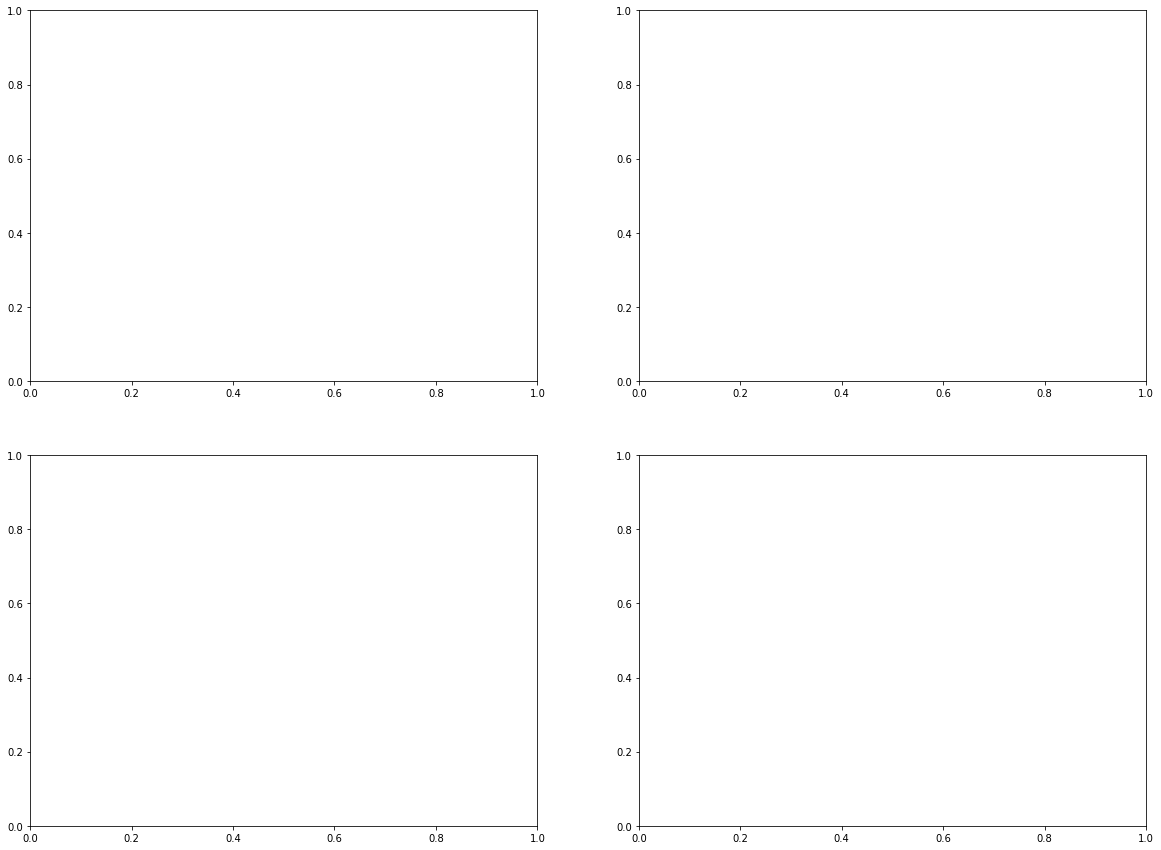

In [23]:

fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
# print(axes)
axes[0][0].plot(
    fold(x, lit_period, lit_t0), y, ".k"
)

axes[0][0].plot(
    fold(no_transit_lks.time.value-x_lk_ref, lit_period, lit_t0),
    y_masked, ",r"
)

axes[1][0].plot(
    fold(x_rv, bls_period, bls_t0), y_rv, ".k",
    label='folded with BLS'
)
axes[1][0].plot(
    fold(x_rv, apo_period, apo_t0), y_rv, "+r",
    label='folded with MAP'
)

axes[1][0].legend()
axes[0][1].plot(x, y, ".k")
axes[0][1].axvline(lit_t0, c='cyan')
axes[0][1].axvline(lit_tn,c='cyan')
axes[1][1].plot(x_rv-min(x_rv), y_rv, "+r")

# x_rv = x_rv - lit_t0

np.all(x_rv[1:] - x_rv[:-1] > 0.0)
axes[1][0].axvline(0.0,ls='--',alpha=0.25)
axes[1][0].axhline(0.0,ls='--',alpha=0.25)


x1m, x1p = axes[0][0].set_xlim()
axes[1][0].set_xlim(x1m,x1p)

In [24]:
def plot_MAP_rv_curve_diagnostic_plot(model, soln, extras, mask, title,
                                        DO_NOT_PLOT=True,
                                         RETURN_FILENAME=False):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    elif 'log_period' in soln.keys():
        period = np.exp(soln['log_period'])
    else:
        period = np.exp(soln['log_period_interval__'])
        
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.min(),x.min()+np.ceil(period))# x.max())
#     ax1.set_xlim(x.max()-10,x.max())# x.max())

#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C1', lw=2)
    
    ax2.set_xlim(x.min(),x.min()+np.ceil(period))# x.max())
#     ax2.set_xlim(x.max()-10,x.max())# x.max())
    
    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = fold(x_rv, period, t0)
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(x_rv_fold, y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    fig_filename = f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png"
    plt.savefig(fig_filename, bbox_inches='tight', dpi=150)
    plt.close()
    
    if RETURN_FILENAME:
        return fig_filename

## PYMC3 BUILD

In [37]:
TIC_TARGET = "TIC 28159019"
pymc3_model_dict = load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=5)

texp = pymc3_model_dict['texp']
x_rv, y_rv, yerr_rv = pymc3_model_dict['x_rv'], pymc3_model_dict['y_rv'], pymc3_model_dict['yerr_rv']
x, y, yerr = pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr']
lk_sigma = pymc3_model_dict['lk_sigma']

lit_period, lit_t0, lit_tn = pymc3_model_dict['lit_period'], pymc3_model_dict['lit_t0'], pymc3_model_dict['lit_tn']
Ntrans, ecosw_tv = pymc3_model_dict['Ntrans'], pymc3_model_dict['ecosw_tv']

iso_M1 = pymc3_model_dict['isores']['M1']
iso_R1 = pymc3_model_dict['isores']['R1']
iso_q = pymc3_model_dict['isores']['q']
iso_k = pymc3_model_dict['isores']['k']
iso_s = pymc3_model_dict['isores']['s']

t = np.linspace(x_rv.min(), x_rv.max(), 5000)
tlc = np.linspace(x.min(), x.max(), 5000)

# rvK = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv*u.km/u.s, yerr_rv*u.km/u.s, t0s=bls_t0)[0]
# print(rvK)

# mask = x < 400
def build_model(mask=None, start=None, plot_MAP_diagnostic_rv_curves=False):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        log_M1 = pm.Normal("log_M1", 
                           mu=np.log(iso_M1), sigma=3.0, 
                           testval=np.log(iso_M1))
#         log_R1 = pm.Uniform('log_R1', lower=np.log(1e-5), upper=np.log(1000))
        log_R1 = pm.Normal("log_R1", 
                           mu=np.log(iso_R1), sigma=3.0, 
                           testval=np.log(iso_R1))
        M1 = pm.Deterministic("M1", tt.exp(log_M1))
        R1 = pm.Deterministic("R1", tt.exp(log_R1))

        
        # Secondary ratios
        log_k = pm.Normal("log_k", mu=np.log(iso_k), sigma=5.0, testval=np.log(iso_k))  # radius ratio        
        log_q = pm.Normal("log_q", mu=np.log(iso_q), sigma=5.0, testval=np.log(iso_q))  # mass ratio
        log_s = pm.Normal("log_s", mu=np.log(iso_s), sigma=5.0, testval = np.log(iso_s))  # surface brightness ratio
        
        
        k = pm.Deterministic("k", tt.exp(log_k))
        q = pm.Deterministic("q", tt.exp(log_q))
        s = pm.Deterministic("s", tt.exp(log_s))

        # Prior on flux ratio
#         pm.Normal(
#             "flux_prior",
#             mu=0.5,
#             sigma=0.25,
#             observed=tt.exp(2 * log_k + log_s),
#         )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=0.5)
#         log_period = pm.Uniform(
#                 "log_period",
#                 lower=np.log(0.1),
#                 upper=np.log(3*lit_period),
#                 testval=np.log(lit_period)
#         )
            
#         log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=5.0)
#         period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)
        tn = pm.Normal("tn", mu=lit_tn, sigma=1.0)
        period = pm.Deterministic("period", (tn - t0) / Ntrans)
        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
#         ecosw_tv=0.01
        sqrt_ecosw = np.sign(ecosw_tv) * np.sqrt(abs(ecosw_tv))
        # ecs is now sqrt(ecs) even if variable name is still ecs
        ecs = pmx.UnitDisk("ecs", testval=np.array([sqrt_ecosw, 0.0]))
        # remove sqrt from ecc, rewrite as ecosW and esinW
        
        
        
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", tt.exp(log_k + log_R1))
        M2 = pm.Deterministic("M2", tt.exp(log_q + log_M1))
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        
        
        
        # Noise model for the light curve
        
        
        
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval= np.mean(yerr),
            **pmx.estimate_inverse_gamma_parameters(0.1,5.0)
        )
        
        
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval= lk_sigma,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval= 2.0 * lit_period,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0)
        )
#         sigma_lc = np.mean(yerr)
#         sigma_gp = lk_sigma
#         rho_gp = 0.25*lit_period
        print(sigma_lc, sigma_gp, rho_gp)
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3.)

#         # Noise model for the radial velocities
#         sigma_rv = pm.InverseGamma(
#             "sigma_rv",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         sigma_rv_gp = pm.InverseGamma(
#             "sigma_rv_gp",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         rho_rv_gp = pm.InverseGamma(
#             "rho_rv_gp",
#             testval=2.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
#         )
#         kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, tt.exp(log_s))

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )

        pm.Deterministic(
            "lc_pred",
            model_lc(x)
        )
        
        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))


#         # Set up the radial velocity model


        log_sigma_rv = pm.Normal(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=20.0
        )

        def model_rv(t):
            return orbit.get_radial_velocity(t, output_units=u.km/u.s) + mean_rv
            
        rv_model = model_rv(x_rv)
        
#         def model_K(t, period, t0):
#             rvs = model_rv(t)
#             modK = xo.estimate_semi_amplitude(period, t, rvs, yerr_rv, t0).to(u.km/u.s)
#             return modK
        
        err = tt.sqrt(yerr_rv**2. + tt.exp(2*log_sigma_rv))
        
        pm.Normal("obs",mu=rv_model, sd=err, observed=y_rv)

        ## compute phased RV signal
        n = 2.*np.pi * (1./period)
        phi = (t0 * n) - omega
        phase = np.linspace(0, 1, 500)
        M_pred = 2 * np.pi * phase - (phi + omega)
        f_pred = xo.orbits.get_true_anomaly(M_pred, ecc + tt.zeros_like(M_pred))
        
#         K = xo.estimate_semi_amplitude(period, t, rv_model, yerr_rv, t0).to(u.km/u.s)
        K = (tt.max(rv_model) - tt.min(rv_model)) / 2.
    
        rvphase = pm.Deterministic(
            "rvphase", K * (tt.cos(omega) * (tt.cos(f_pred) + ecc) - tt.sin(omega) * tt.sin(f_pred))
        )
        
        # Optimize the logp
        if start is None:
            start = model.test_point

            
        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )
        
        
        # First the RV parameters
        print(model.check_test_point())
        opti_logp = []
        filename_list = []
        map_vars_dict = {
            't0_tn' : [tn,t0],
#             'log_k' : log_k,
            'log_q' : log_q,
            'log_s' : log_s,
            'log_M1': log_M1,
            'log_R1': log_R1,
            'mean_lc': mean_lc,
            'mean_rv': mean_rv
        }
        list_of_map_vars = list(map_vars_dict.keys())
        
        
        map_soln, info_ = pmx.optimize(start, log_k, return_info=True)
        plot1 = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after start point opt step',RETURN_FILENAME=True)
        filename_list.append(plot1)
        
        map_soln, info_ = pmx.optimize(map_soln, [b], return_info=True)
        plot2 = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [b] opt step',RETURN_FILENAME=True)
        filename_list.append(plot2)

#         map_soln, info_ = pmx.optimize(map_soln, [log_s], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, log_M1, return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [tn, t0], return_info=True)        
#         map_soln, info_ = pmx.optimize(map_soln, [log_k, b, log_s, tn, t0, u1, u2, log_M1], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [u1,u2], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [log_q], return_info=True)

        map_soln, info_ = pmx.optimize(map_soln, [ecs], return_info=True)
        plot3 = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [ecs] opt step', RETURN_FILENAME=True)
        filename_list.append(plot3)
        if ~np.isfinite(-info_['fun']):
            list_of_map_vars.append('ecs')
            map_vars_dict['ecs'] = ecs
        
#         list_of_map_vars = [
#                 log_s,
#                 log_M1,
#                 [tn, t0],
# #                 [log_k, b, log_s, tn, t0, u1, u2, log_M1],
# #                 [u1,u2],
#                 [log_q],
# #                 log_sigma_rv,
#                 mean_lc,
#                 mean_rv
#         ]

        

        best_map_list = []
        whileloop_failsafe = 0
        while len(list_of_map_vars) > 0:
            highest_logp = -np.inf
            try:
                next_map_var = []
                next_map_soln = []
                next_opti_logp = np.nan
                for ii in list_of_map_vars:
#                     print(f"optimizing {ii}") 
                    map_soln_ii, info_ = pmx.optimize(map_soln, map_vars_dict[ii], return_info=True, verbose=False)
                    
                    if np.isfinite(-info_['fun']):
                        if -info_['fun'] > highest_logp:
                            next_map_var = ii
                            next_map_soln = map_soln_ii
                            next_opti_logp = -info_['fun']
                            highest_logp = -info_['fun']
                            
                opti_logp.append(next_opti_logp)
                map_soln = next_map_soln
                list_of_map_vars.remove(next_map_var)
                best_map_list.append(next_map_var)
                
                print("-"*50)
                print(f"N_best: {len(best_map_list)}, N_left: {len(list_of_map_vars)}, {next_map_var}")
                plotn = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after {next_map_var} opt step', RETURN_FILENAME=True)
                filename_list.append(plotn)
            except:
                print("loop failed")
                whileloop_failsafe += 1
                print(whileloop_failsafe)
            if whileloop_failsafe > 20:
                break
#         map_soln, info_ = pmx.optimize(map_soln, [mean_lc, rho_gp, sigma_gp, sigma_lc], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [log_sigma_rv], return_info=True)
#         map_soln, info_ = pmx.optimize(map_soln, [ecs], return_info=True)



        map_soln, info_ = pmx.optimize(map_soln, [u1,u2], return_info=True)
        plot4 = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [u1, u2] opt step', RETURN_FILENAME=True)
        filename_list.append(plot4)
        
        map_soln, info_ = pmx.optimize(map_soln, [log_sigma_rv], return_info=True)
        plot5 = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [log_sigma_rv] opt step', RETURN_FILENAME=True)
        filename_list.append(plot5)
        
        
        map_soln, info_ = pmx.optimize(map_soln, [sigma_lc, sigma_gp, rho_gp], return_info=True)
        plot6 = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after GP params opt step', RETURN_FILENAME=True)
        filename_list.append(plot6)
        
        map_soln, info_ = pmx.optimize(map_soln, [b, ecs, log_k, log_q, log_s, tn, t0, u1, u2, log_M1, sigma_lc, sigma_gp, rho_gp, log_sigma_rv], return_info=True)
        plot7 = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after final opt step', RETURN_FILENAME=True)
        filename_list.append(plot7)




#         opti_logp.append(-info_['fun'])
#         if plot_MAP_diagnostic_rv_curves:
#             plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title='start_times')
#             assert False
#         #         map_vars = [mean_lc, mean_rv, b, log_R1, 
# #                     log_k, log_s, ecs, u1, u2, t0, 
# #                     log_period, sigma_lc, sigma_rv, 
# #                     sigma_gp, sigma_rv_gp, rho_gp, rho_rv_gp]
        
#         map_vars = [ [tn,t0], ecs, b,
#                     [ecs, b],
#                     log_q, log_s, log_k,
#                      log_M1, log_R1,
#                     log_sigma_rv, mean_rv,
#                     [mean_rv, log_q, ecs],
#                     [mean_lc, rho_gp, sigma_gp, sigma_lc],
#                     [mean_lc,u1,u2]
#                     ]

        
        
# #         map_vars = [[log_period, t0]]#,log_q, log_s, [ecs, b, log_k], [mean_lc,u1,u2], log_M1, log_R1,
# #         map_soln = pmx.optimize(
# #             map_soln, [mean_rv, sigma_rv1, sigma_rv2, sigma_rv_gp, rho_rv_gp]
# #         )


    


#         }
#         map_vars_names = np.array(list(map_vars_dict.keys()))
#         print(map_vars_names)
        
#         failed_mvar_list = []
#         for ii,mvar_grp in enumerate(map_vars_names):
#             map_soln, info_ = pmx.optimize(
#                                     map_soln, 
#                                     vars = map_vars_dict[mvar_grp], 
#                                     return_info=True
#             )
#             if np.isfinite(info_['fun']):
#                 opti_logp.append(-info_['fun'])
#                 if plot_MAP_diagnostic_rv_curves:
#                     plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after {mvar_grp} opt')
#             else:
#                 #mar_vars_names = np.insert(map_vars_names, ii+2, mvar_grp)
#                 failed_mvar_list.append(mvar_grp)
                
#             if len(failed_mvar_list) > 0:
#                 for failed_mvar in failed_mvar_list:
#                     map_soln, info_ = pmx.optimize(
#                                         map_soln, 
#                                         vars = map_vars_dict[failed_mvar], 
#                                         return_info=True
#                     )
#                     if np.isfinite(info_['fun']):
#                         opti_logp.append(-info_['fun'])
#                         if plot_MAP_diagnostic_rv_curves:
#                             plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
#                                                               title=f'RVs after {failed_mvar} opt')
#                         failed_mvar_list.remove(failed_mvar)
#                     else:
#                         continue


    return model, map_soln, extras, start, opti_logp, filename_list



# working_params = []
# final_model_logp = []
# for ii in range(100):
#     try:
#         sigma_lc_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
#         sigma_lc_gaminv_beta = np.round(np.random.uniform(low=1.0,high=25.0),0)
        
#         sigma_gp_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
#         sigma_gp_gaminv_beta = np.round(np.random.uniform(low=1.0,high=25.),0)
        
#         rho_gp_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
#         rho_gp_gaminv_beta = np.round(np.random.uniform(low=1.0,high=10.0),0)
        
#         model, map_soln, extras, start, opti_logp = build_model(lc_gp_params=[
#                                                                     sigma_lc_gaminv_alph,
#                                                                     sigma_lc_gaminv_beta,
#                                                                     sigma_gp_gaminv_alph,
#                                                                     sigma_gp_gaminv_beta,
#                                                                     rho_gp_gaminv_alph,
#                                                                     rho_gp_gaminv_beta
#         ])
#         working_params.append([sigma_lc_gaminv_alph,
#                                 sigma_lc_gaminv_beta,
#                                 sigma_gp_gaminv_alph,
#                                 sigma_gp_gaminv_beta,
#                                 rho_gp_gaminv_alph,
#                                 rho_gp_gaminv_beta])
#         final_model_logp.append(opti_logp[-1])
#     except:
#         pass

model, map_soln, extras, start, opti_logp, filename_list = build_model(plot_MAP_diagnostic_rv_curves=True)

import imageio
images = []

filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
for filename in filename_list:
    images.append(imageio.imread(filename))
imageio.mimsave(f'/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_diagnostic_movie_test.gif', images, fps=0.75)

print("#" * 50)
print("#"*19 +"  FINISHED  " + "#"*19)
print("#"*50)

1.2427787691614327 1.0924356675899376 1 0
1.2427787691614327 1.0924356675899376 3.2388661664044127 4.037330373154673
0.001388888888888889 120.00000000000003
1.1389999999998963
lightcurve N datapoints:  10745 10745 10745 transit_epoch:  1.1389999999998963
3.3133538
165.0
sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                         -3.22
mean_rv                         -4.83
u1_quadlimbdark__               -2.77
u2_quadlimbdark__               -2.77
log_M1                          -2.02
log_R1                          -2.02
log_k                           -2.53
log_q                           -2.53
log_s                           -2.53
b_impact__                      -1.58
t0                              -0.92
tn                              -0.92
ecs_unitdisk+interval__         -2.31
sigma_lc_log__                  -3.05
sigma_gp_log__                  -2.69
rho_gp_log__                    -4.11
log_sigma_rv                    -3.91
obs_lc       

optimizing logp for variables: [log_k]


message: Desired error not necessarily achieved due to precision loss.
logp: -1845582.7216150789 -> -106364.08566058142
optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -106364.08566058142 -> -105904.47514182626
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -105904.47514182626 -> -76983.60785440239


--------------------------------------------------
N_best: 1, N_left: 6, log_q
--------------------------------------------------
N_best: 2, N_left: 5, log_s
--------------------------------------------------
N_best: 3, N_left: 4, log_R1
--------------------------------------------------
N_best: 4, N_left: 3, t0_tn
--------------------------------------------------
N_best: 5, N_left: 2, log_M1
--------------------------------------------------
N_best: 6, N_left: 1, mean_lc
--------------------------------------------------
N_best: 7, N_left: 0, mean_rv


optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -34707.06532916986 -> -32620.223957555987
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -32620.223957555987 -> -30146.491978795097
optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -30146.491978795097 -> -27108.70407088219
optimizing logp for variables: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, log_M1, u2, u1, t0, tn, log_s, log_q, log_k, ecs, b]


message: Desired error not necessarily achieved due to precision loss.
logp: -27108.70407088219 -> -25899.562920072367


##################################################
###################  FINISHED  ###################
##################################################


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [39]:
file = open("tic28159019_joint_mod_individual_priors_map_soln.pickle",'wb')
pk.dump(map_soln, file)
file.close()

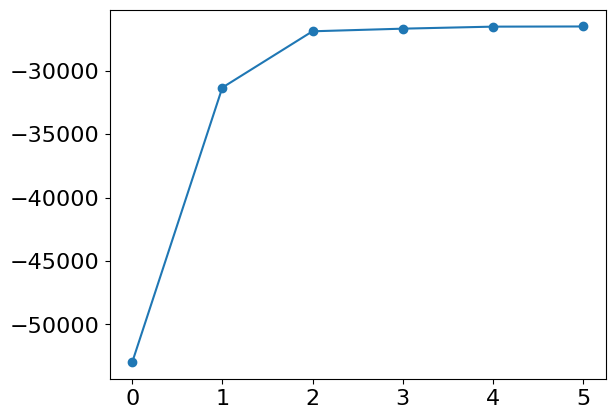

In [55]:
# print(np.exp(map_soln['log_period']),lit_period,(np.exp(map_soln['log_period'])-lit_period) )
# print(jk_row['MAP_P'])
# print(start.keys())
# print(best_map_list)
fig,ax = plt.subplots()
ax.plot(range(len(opti_logp)), opti_logp,'o-')


{'mean_lc': array(0.), 'mean_rv': array(0.), 'u1_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'u2_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'log_M1': array(0.21734982), 'log_R1': array(0.48308535), 'log_k': array(-0.30475783), 'log_q': array(-0.12894005), 'log_s': array(0.22036035), 'b_impact__': array(-0.90608031), 't0': array(1.139), 'tn': array(763.2109654), 'ecs_unitdisk+interval__': array([-1.64969106,  0.        ]), 'sigma_lc_log__': array(1.06346945), 'sigma_gp_log__': array(1.1979609), 'rho_gp_log__': array(2.2232427), 'log_sigma_rv': array(-1.21106004)}


<Figure size 864x576 with 0 Axes>

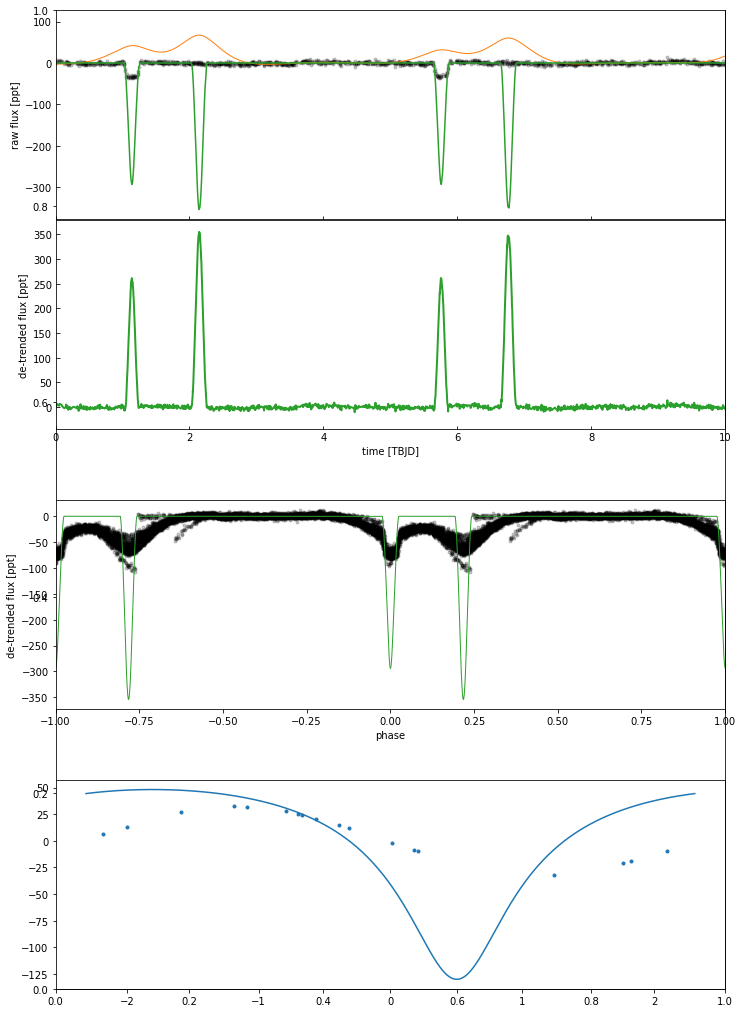

In [40]:
def plot_diagnostic_plots(soln, extras, mask, title,
                                        DO_NOT_SAVE=True):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    else:
        period = (soln['tn'] - soln['t0']) / Ntrans
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.min(),x.min()+10.)# x.max())
#     ax1.set_xlim(x.max()-10,x.max())# x.max())

#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C2', lw=2)
    
    ax2.set_xlim(x.min(),x.min()+10)# x.max())
#     ax2.set_xlim(x.max()-10,x.max())# x.max())
    
    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(fold(x_rv,period,t0), y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    if DO_NOT_SAVE is False:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png",
                bbox_inches='tight', dpi=150)
        plt.close()
    
plot_diagnostic_plots(start, extras, mask=None, title='',DO_NOT_SAVE=True),
print(start)

<Figure size 864x576 with 0 Axes>

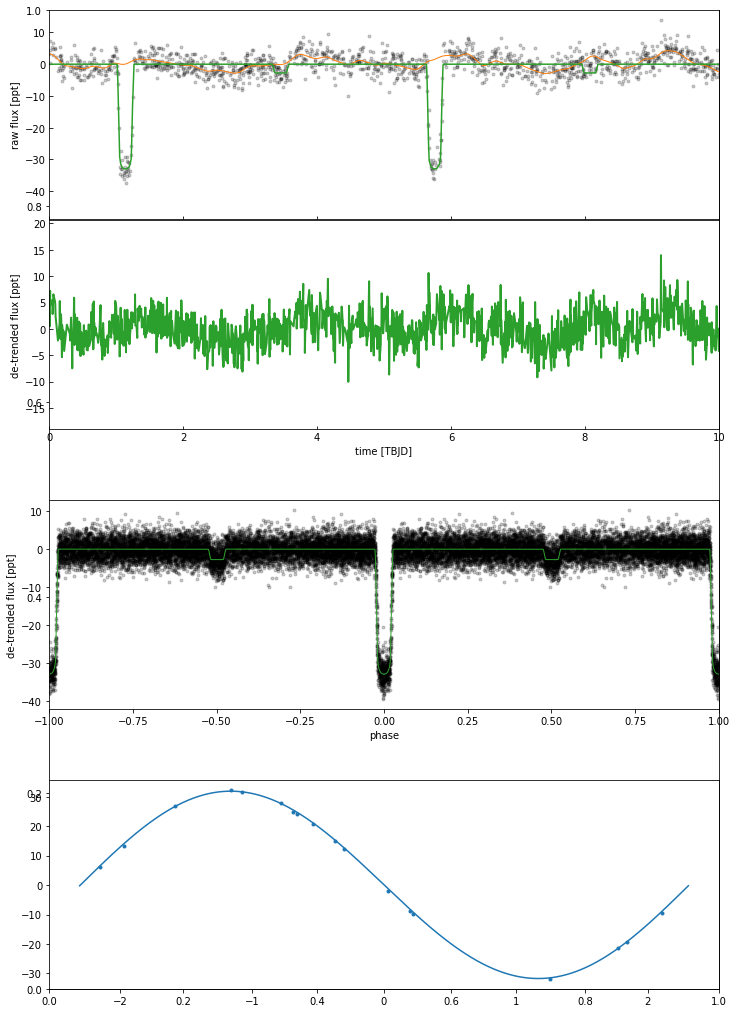

In [41]:
plot_diagnostic_plots(map_soln, extras, title='',mask=None)
plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_plot_after_brute_force_MAP.png",dpi=150, bbox_inches='tight')

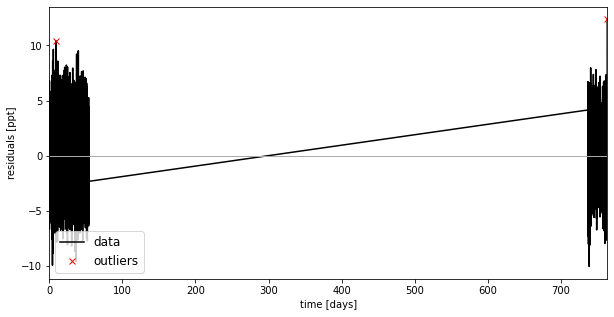

In [42]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 6 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                         -3.22
mean_rv                         -4.83
u1_quadlimbdark__               -2.77
u2_quadlimbdark__               -2.77
log_M1                          -2.02
log_R1                          -2.02
log_k                           -2.53
log_q                           -2.53
log_s                           -2.53
b_impact__                      -1.58
t0                              -0.92
tn                              -0.92
ecs_unitdisk+interval__         -2.31
sigma_lc_log__                  -3.05
sigma_gp_log__                  -2.69
rho_gp_log__                    -4.11
log_sigma_rv                    -3.91
obs_lc                    -1777077.23
obs                         -65968.30
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -25874.497921657858 -> -25874.488077817936
optimizing logp for variables: [b, log_k]


message: Desired error not necessarily achieved due to precision loss.
logp: -25874.488077817936 -> -25874.485374740183
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -25874.485374740183 -> -25874.48531415815


--------------------------------------------------
N_best: 1, N_left: 6, mean_lc
--------------------------------------------------
N_best: 2, N_left: 5, mean_rv
--------------------------------------------------
N_best: 3, N_left: 4, log_q
--------------------------------------------------
N_best: 4, N_left: 3, log_R1
--------------------------------------------------
N_best: 5, N_left: 2, t0_tn
--------------------------------------------------
N_best: 6, N_left: 1, log_s
--------------------------------------------------
N_best: 7, N_left: 0, log_M1


optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -25866.345858561093 -> -25866.32295883852
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -25866.32295883852 -> -25864.908488294892
optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Optimization terminated successfully.
logp: -25864.908488294892 -> -25864.491791882385
optimizing logp for variables: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, log_M1, u2, u1, t0, tn, log_s, log_q, log_k, ecs, b]


message: Optimization terminated successfully.
logp: -25864.491791882385 -> -25863.915074891174


10745 10743


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

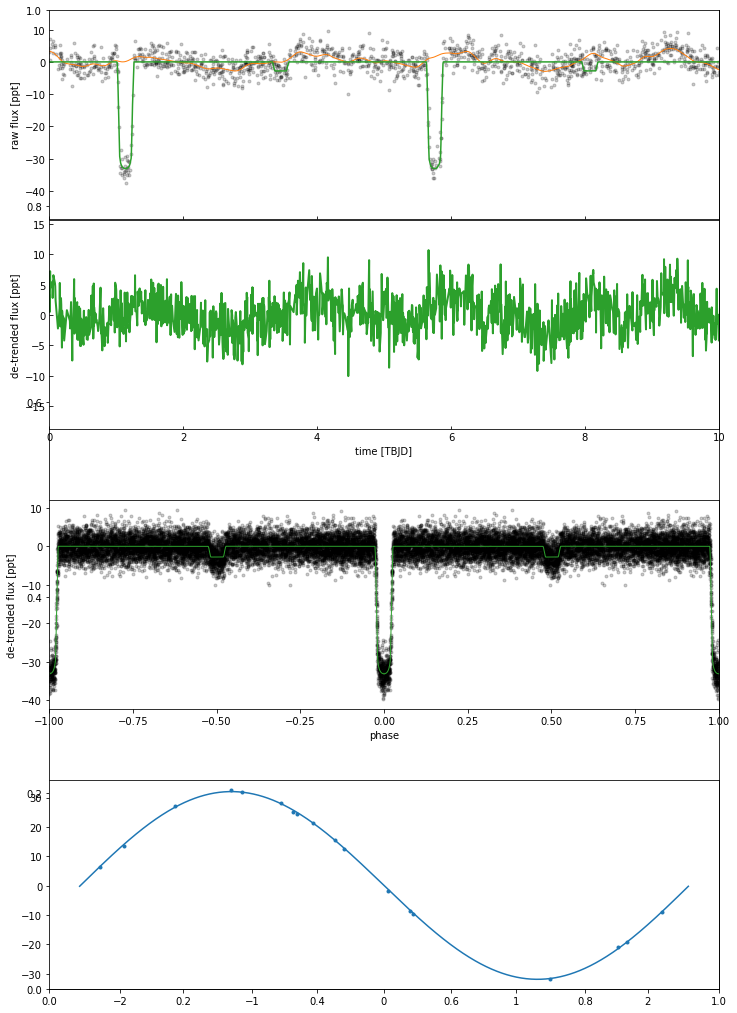

In [43]:
model, map_soln, extras, start, opti_logp,_ = build_model(mask, map_soln)
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None,title='')
# plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')

In [44]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=500,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=4,
        chains=4,
        target_accept=0.99,
        return_inferencedata=True,
        random_seed=[261136681, 261136682,261136683,261136684],
        init='adapt_full'
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5117 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


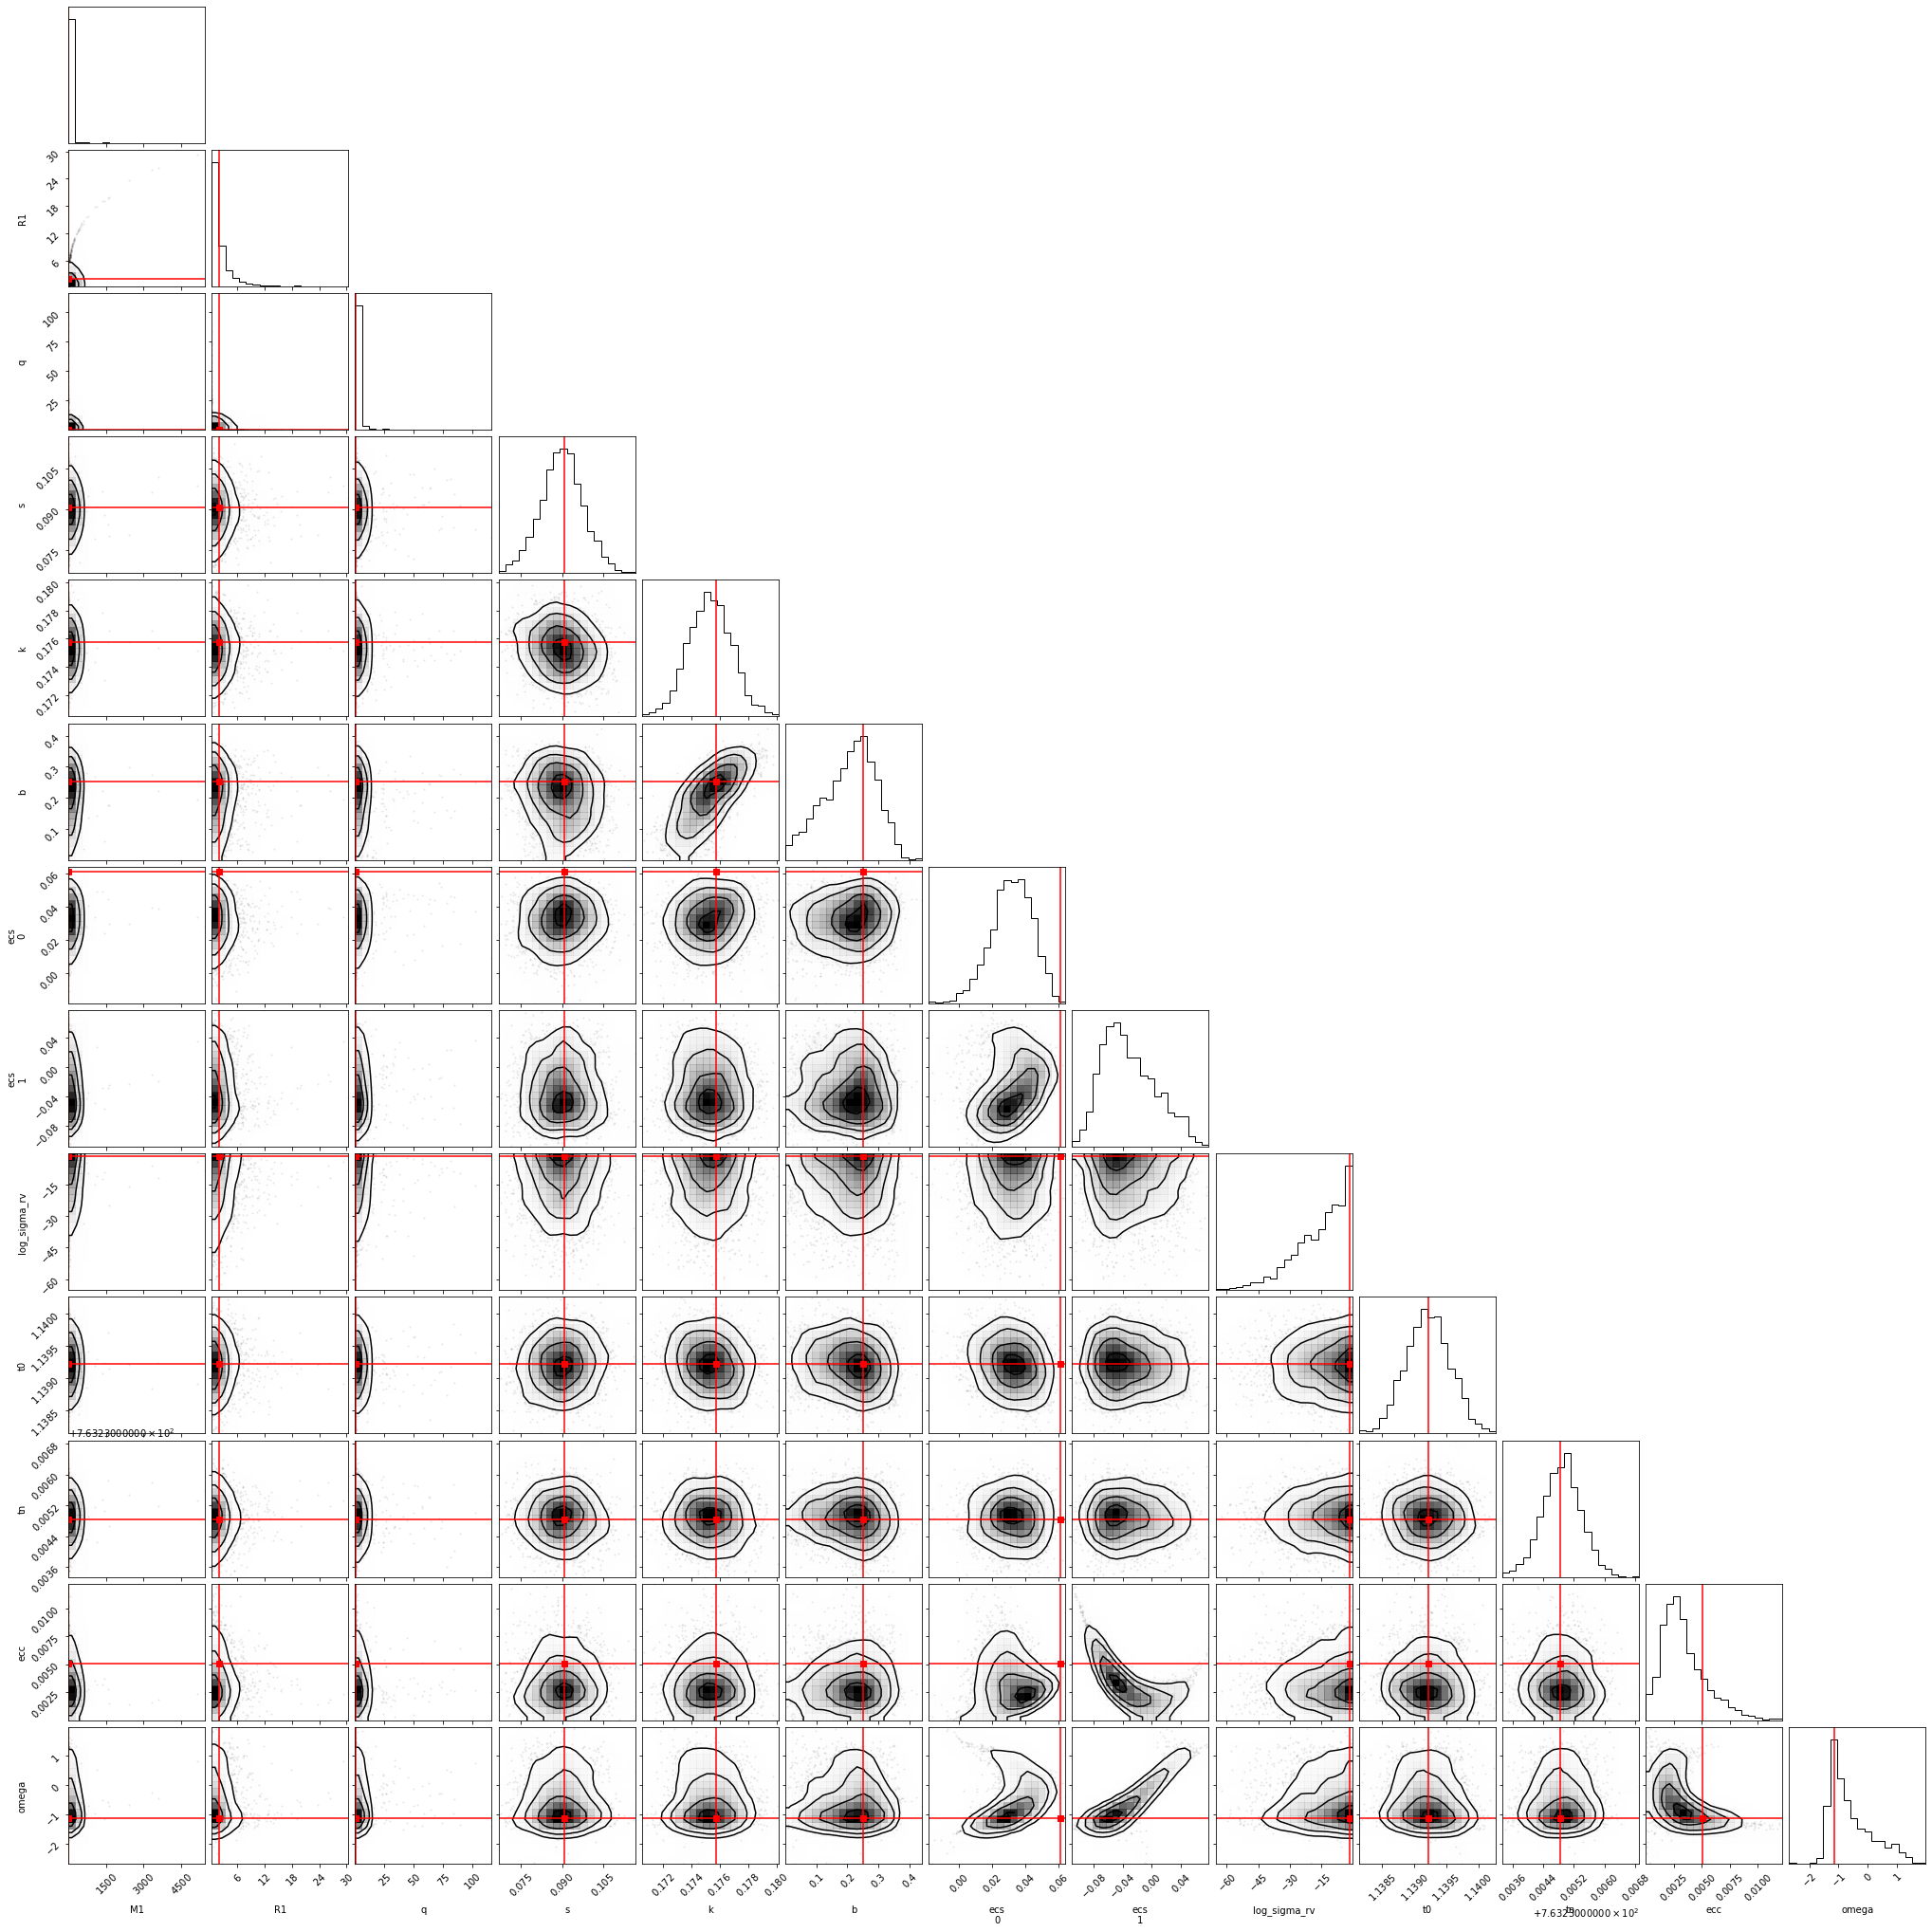

In [45]:
_ = corner(trace, var_names=['M1','R1','q','s','k','b','ecs','log_sigma_rv','t0','tn','ecc', 'omega'], smooth=1, use_math_text=True,
          truths=[map_soln['M1'], map_soln['R1'], map_soln['q'], map_soln['s'], map_soln['k'], map_soln['b'], 
                  map_soln['ecs_unitdisk+interval__'][0],map_soln['ecs_unitdisk+interval__'][1], map_soln['log_sigma_rv'], 
                  map_soln['t0'], map_soln['tn'], map_soln['ecc'], map_soln['omega']],
            truth_color='red', range=[1,1,1,1,1,1,1,1,1,1,1,1,1])
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_')}_joint_rv_lightcurve_corner_w_individual_priors.png",bbox_inches='tight', dpi=150)

In [46]:
az.summary(trace, var_names=['period','log_q','log_s','log_k','log_R1','log_M1','u1','u2','mean_lc','b','t0','tn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,4.619,0.000,4.619,4.619,0.000,0.000,2841.0,1313.0,1.00
log_q,-0.701,1.465,-3.060,2.419,0.131,0.093,187.0,74.0,1.02
log_s,-2.413,0.087,-2.583,-2.253,0.002,0.001,2862.0,1524.0,1.00
log_k,-1.741,0.009,-1.759,-1.726,0.000,0.000,783.0,1265.0,1.00
log_R1,0.466,0.826,-0.850,1.875,0.046,0.033,187.0,70.0,1.02
log_M1,-0.822,3.065,-6.416,5.138,0.223,0.229,187.0,74.0,1.02
u1[0],0.085,0.060,0.000,0.195,0.002,0.001,905.0,749.0,1.01
u1[1],0.288,0.152,-0.019,0.543,0.005,0.004,803.0,989.0,1.00
u2[0],0.670,0.477,0.001,1.488,0.009,0.007,2342.0,1387.0,1.00
u2[1],0.004,0.417,-0.721,0.797,0.008,0.008,2395.0,1377.0,1.00


In [48]:
from pymc3.util import get_default_varnames, get_untransformed_name, is_transformed_name
import theano

def compute_value_in_post(model, idata, target, size=None):
    # Get the names of the untransformed variables
    vars = get_default_varnames(model.unobserved_RVs, True)
    names = list(sorted(set([
        get_untransformed_name(v.name)
        if is_transformed_name(v.name)
        else v.name
        for v in vars
    ])))

    # Compile a function to compute the target
    func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

    # Call this function for a bunch of values
    flat_samps = idata.posterior.stack(sample=("chain", "draw"))
    if size is None:
        indices = np.arange(len(flat_samps.sample))
    else:
        indices = np.random.randint(len(flat_samps.sample), size=size)

    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]


rvvals = compute_value_in_post(model, trace, extras['model_rv'](t), size=1000)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=1000)
print(np.shape(rvvals), np.shape(lcvals))
# inds = np.argsort(foldedtrv)
# for ii in range(1000):
#     axes.plot(foldedtrv,rvals[ii],'.r',alpha=0.1)
# axes.hist(rvals)
print(np.percentile(rvvals, [16,50,84],axis=0).shape)

(1000, 5000) (1000, 5000)
(3, 5000)


<xarray.DataArray 'ecc' ()>
array(0.00294288)


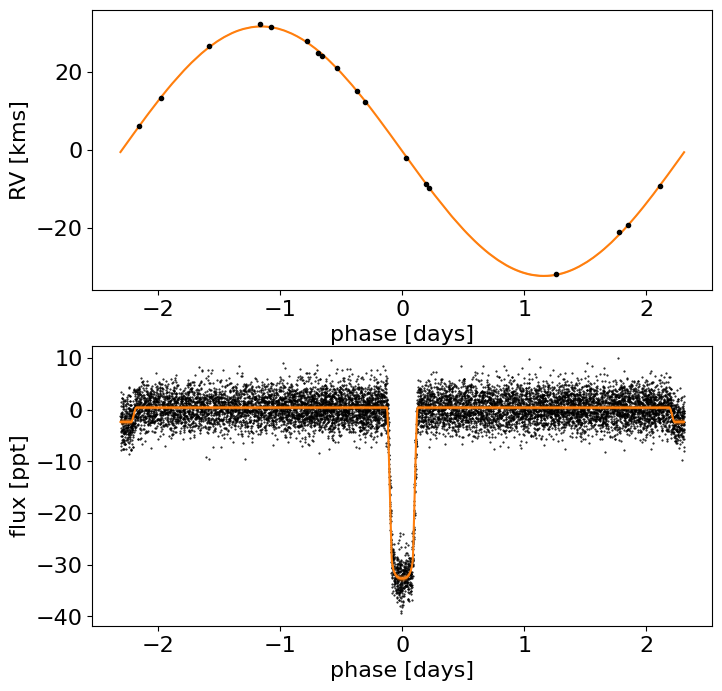

In [50]:
xo.utils.docs_setup()


# phase = np.linspace(0,1.,500)
# per = trace.posterior['period'].values
# t0 = trace.posterior['t0'].values
# x_phase = np.linspace(-0.5*np.median(per), 0.5*np.median(per), 100)

# mu_rv = trace.posterior['mean_rv'].values

flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# bkg = trace.posterior["mean_rv"].values
# rvphase = trace.posterior["rvphase"].values
# mcmc_per = trace.posterior['period'].values
p_med = flat_samps['period'].median().values
t0_med = flat_samps['t0'].median().values
mean_rv = flat_samps['mean_rv'].median().values
mean_lc = flat_samps['mean_lc'].median().values
# gp_pred = flat_samps['gp_pred'].median().values

fig, axes = plt.subplots(figsize=(8, 8), ncols=1, nrows=2)
print(flat_samps['ecc'].median())

axes[0].errorbar(fold(x_rv, p_med, t0_med),
              y_rv, yerr=yerr_rv, fmt=".k")

    
t_fold = fold(t, p_med, t0_med)
inds = np.argsort(t_fold)
pred = np.percentile(rvvals, [16, 50, 84], axis=0)
axes[0].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(rvvals, [16, 84], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(rvvals, [5, 95], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(rvvals, [1, 99], axis=0)
# art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")
# axes[0].set_ylim(-40, 40)
# axes[1].set_ylim(-40, 40)
axes[0].set_xlabel('phase [days]')
axes[0].set_ylabel("RV [kms]")

x,y = extras['x'],extras['y']
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln)
    )
axes[1].errorbar(fold(x, p_med, t0_med),
              y-gp_pred, fmt=".k", ms=1, zorder=-1)

t_fold = fold(tlc, p_med, t0_med)
inds = np.argsort(t_fold)
pred = np.percentile(lcvals, [16, 50, 84], axis=0)
axes[1].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(lcvals, [16, 84], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(lcvals, [5, 95], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
# art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")

axes[1].set_xlabel("phase [days]")
axes[1].set_ylabel("flux [ppt]")
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_').replace('-','_')}_sampled_rvphase_plot.png",dpi=150,bbox_inches='tight')
# plt.tight_layout()